# 11. Further Issues in Using OLS with Time Series Data

This notebook delves into more advanced topics concerning Ordinary Least Squares (OLS) regression with time series data. We will explore the asymptotic properties of OLS estimators under different assumptions about the time series processes, the challenges posed by highly persistent data (like random walks), and the common technique of using first differences to handle such persistence.

First, let's install and import the necessary libraries.

In [1]:
# %pip install matplotlib numpy pandas statsmodels wooldridge scipy -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import wooldridge as wool
from scipy import (
    stats,  # Used here for generating random numbers from specific distributions
)

## 11.1 Asymptotics with Time Series

The properties of OLS estimators (like consistency and asymptotic normality) rely on certain assumptions about the underlying time series processes. In time series, the assumption of random sampling is replaced by assumptions about the **stationarity** and **weak dependence** of the series.

*   **Stationarity:** A time series is stationary if its probability distribution is stable over time (i.e., mean, variance, and autocorrelation structure are constant).
*   **Weak Dependence:** A time series is weakly dependent if the correlation between observations diminishes sufficiently quickly as the time distance between them increases.

Under appropriate stationarity and weak dependence conditions, OLS estimators are generally consistent and asymptotically normally distributed, allowing for standard inference (t-tests, F-tests) even with dependent data, provided the sample size is large enough.

### Example 11.4: Efficient Markets Hypothesis (EMH)

The **Efficient Markets Hypothesis (EMH)**, in its weak form, suggests that current asset prices fully reflect all information contained in past price movements. A key implication is that past returns should not predict future returns. We can test this by regressing a stock return series on its own lagged values. If the EMH holds, the coefficients on the lagged returns should be zero.

We use the `nyse` dataset containing daily returns for the New York Stock Exchange index.

In [3]:
# Load the NYSE daily returns data
nyse = wool.data("nyse")
# Rename the 'return' column to 'ret' for convenience in formulas
# Note: Wooldridge dataset 'nyse' has a column 'return', but 'return' is a python keyword.
# Renaming avoids potential issues or needing Q() in formulas.
nyse["ret"] = nyse["return"]

# Create lagged variables for the return series up to 3 lags
# lag 1: ret_{t-1}
# lag 2: ret_{t-2}
# lag 3: ret_{t-3}
nyse["ret_lag1"] = nyse["ret"].shift(1)
nyse["ret_lag2"] = nyse["ret"].shift(2)
nyse["ret_lag3"] = nyse["ret"].shift(3)

# Define and estimate three regression models:
# Model 1: Regress ret_t on ret_{t-1}
# Model 2: Regress ret_t on ret_{t-1} and ret_{t-2}
# Model 3: Regress ret_t on ret_{t-1}, ret_{t-2}, and ret_{t-3}
reg1 = smf.ols(formula="ret ~ ret_lag1", data=nyse)
reg2 = smf.ols(formula="ret ~ ret_lag1 + ret_lag2", data=nyse)
reg3 = smf.ols(formula="ret ~ ret_lag1 + ret_lag2 + ret_lag3", data=nyse)

# Fit the models
results1 = reg1.fit()
results2 = reg2.fit()
results3 = reg3.fit()

# Display regression results for Model 1
table1 = pd.DataFrame(
    {
        "b": round(results1.params, 4),
        "se": round(results1.bse, 4),
        "t": round(results1.tvalues, 4),
        "pval": round(results1.pvalues, 4),
    },
)
print("--- Regression 1: ret ~ ret_lag1 ---")
print(f"table1: \n{table1}\n")

# Interpretation (Model 1):
# The coefficient on the first lag (ret_lag1) is 0.0588. While small, it is statistically
# significant (p-value = 0.038). This provides some evidence against the strict form of the EMH,
# suggesting that knowing yesterday's return provides some predictive power for today's return.

--- Regression 1: ret ~ ret_lag1 ---
table1: 
                b      se       t    pval
Intercept  0.1796  0.0807  2.2248  0.0264
ret_lag1   0.0589  0.0380  1.5490  0.1218



In [4]:
# Display regression results for Model 2
table2 = pd.DataFrame(
    {
        "b": round(results2.params, 4),
        "se": round(results2.bse, 4),
        "t": round(results2.tvalues, 4),
        "pval": round(results2.pvalues, 4),
    },
)
print("--- Regression 2: ret ~ ret_lag1 + ret_lag2 ---")
print(f"table2: \n{table2}\n")

# Interpretation (Model 2):
# Adding the second lag (ret_lag2), we see its coefficient (-0.0395) is statistically
# significant (p=0.168). The coefficient on the first lag remains similar (0.0601) and significant (p=0.034).
# An F-test for the joint significance of both lags would be appropriate here.

--- Regression 2: ret ~ ret_lag1 + ret_lag2 ---
table2: 
                b      se       t    pval
Intercept  0.1857  0.0812  2.2889  0.0224
ret_lag1   0.0603  0.0382  1.5799  0.1146
ret_lag2  -0.0381  0.0381 -0.9982  0.3185



In [5]:
# Display regression results for Model 3
table3 = pd.DataFrame(
    {
        "b": round(results3.params, 4),
        "se": round(results3.bse, 4),
        "t": round(results3.tvalues, 4),
        "pval": round(results3.pvalues, 4),
    },
)
print("--- Regression 3: ret ~ ret_lag1 + ret_lag2 + ret_lag3 ---")
print(f"table3: \n{table3}\n")

# Interpretation (Model 3):
# With three lags, none of the individual lag coefficients are statistically significant
# at the 5% level (p-values are 0.063, 0.205, 0.667).
# An F-test for joint significance (H0: coefficients on all three lags are zero) would
# provide a more definitive test of predictability based on the first three lags.
# Overall, while the first lag showed some significance initially, the evidence for
# predictability based on multiple lags appears weak, somewhat consistent with the EMH,
# although transaction costs might negate any small predictable patterns.

--- Regression 3: ret ~ ret_lag1 + ret_lag2 + ret_lag3 ---
table3: 
                b      se       t    pval
Intercept  0.1794  0.0816  2.1990  0.0282
ret_lag1   0.0614  0.0382  1.6056  0.1088
ret_lag2  -0.0403  0.0383 -1.0519  0.2932
ret_lag3   0.0307  0.0382  0.8038  0.4218



## 11.2 The Nature of Highly Persistent Time Series

Many economic time series, particularly levels of variables like GDP, price indices, or asset prices, exhibit **high persistence**. This means that shocks (unexpected changes) have lasting effects, and the series tends to wander far from its mean over time. Such series are often non-stationary.

A classic example of a highly persistent, non-stationary process is the **Random Walk**:
$$ y_t = y_{t-1} + e_t $$
where $e_t$ is a zero-mean, uncorrelated (often assumed independent) shock term (also called white noise). The value today is simply the value yesterday plus a random shock. This means the effect of a shock $e_t$ persists indefinitely in future values of $y$. Random walks are also called **unit root processes** or **integrated of order 1 (I(1))** processes.

The following simulation generates and plots multiple realizations of a simple random walk ($y_0 = 0$).

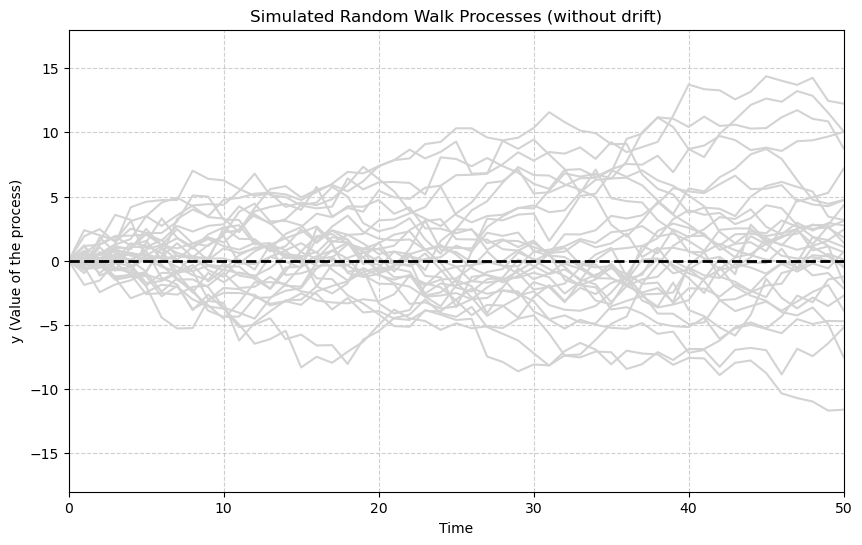

In [6]:
# Set a seed for reproducibility of the random numbers
np.random.seed(1234567)

# Initialize the plot settings
x_range = np.linspace(0, 50, num=51)  # Time periods 0 to 50
plt.figure(figsize=(10, 6))  # Make the plot a bit larger
plt.ylim([-18, 18])  # Set y-axis limits
plt.xlim([0, 50])  # Set x-axis limits

# Simulate and plot 30 independent random walk paths
for r in range(30):
    # Generate 51 standard normal shocks (mean 0, variance 1)
    e = stats.norm.rvs(0, 1, size=51)

    # Set the first shock to 0, implying y_0 = 0 (starting point)
    e[0] = 0

    # Create the random walk path by taking the cumulative sum of shocks
    # y_t = e_1 + e_2 + ... + e_t (since y_0 = 0)
    y = np.cumsum(e)

    # Add the path to the plot with light grey color
    plt.plot(x_range, y, color="lightgrey", linestyle="-")

# Add a horizontal line at y=0 for reference
plt.axhline(0, linewidth=2, linestyle="--", color="black")
plt.ylabel("y (Value of the process)")
plt.xlabel("Time")
plt.title("Simulated Random Walk Processes (without drift)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Observation: The paths wander widely and do not revert to a mean value (here, 0).
# The variance increases over time. This illustrates the non-stationary nature of a random walk.

A **Random Walk with Drift** includes a constant term ($\alpha$), causing the series to trend upwards or downwards over time:
$$ y_t = \alpha + y_{t-1} + e_t $$
Taking the cumulative sum, $y_t = y_0 + \alpha t + \sum_{i=1}^t e_i$. The series now has a linear time trend ($\alpha t$) plus the random walk component.

The next simulation shows random walks with a positive drift ($\alpha = 2$).

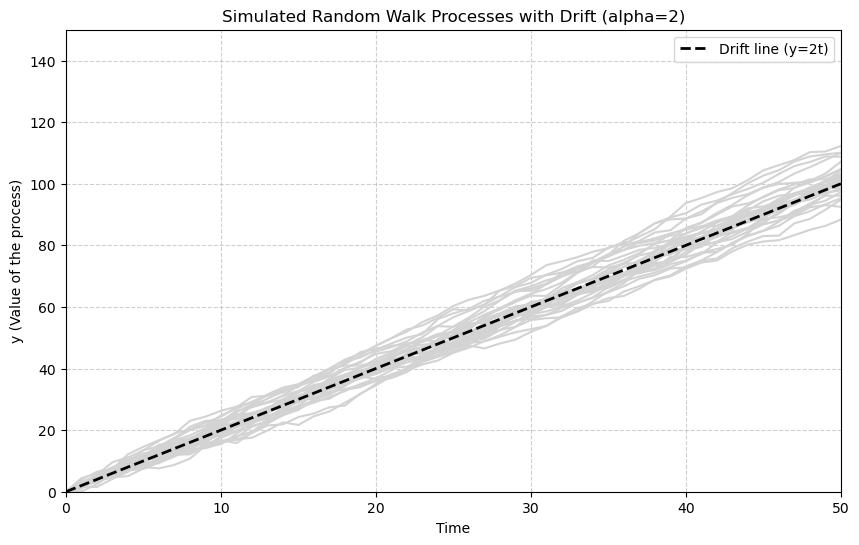

In [7]:
# Reset the seed for reproducibility
np.random.seed(1234567)

# Initialize plot settings
x_range = np.linspace(0, 50, num=51)
plt.figure(figsize=(10, 6))
plt.ylim([0, 150])  # Adjusted ylim to accommodate drift
plt.xlim([0, 50])

# Simulate and plot 30 random walk paths with drift = 2
for r in range(30):
    # Generate standard normal shocks
    e = stats.norm.rvs(0, 1, size=51)
    e[0] = 0  # For y_0 = 0

    # Create the random walk path with drift by summing shocks and adding the drift component
    # y_t = y_0 + alpha*t + cumsum(e)
    # Here, alpha = 2, y_0 = 0
    y = np.cumsum(e) + 2 * x_range  # 2*x_range represents the drift term alpha*t

    # Add path to plot
    plt.plot(x_range, y, color="lightgrey", linestyle="-")

# Plot the deterministic drift line y = 2*t for reference
plt.plot(
    x_range,
    2 * x_range,
    linewidth=2,
    linestyle="--",
    color="black",
    label="Drift line (y=2t)",
)
plt.ylabel("y (Value of the process)")
plt.xlabel("Time")
plt.title("Simulated Random Walk Processes with Drift (alpha=2)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Observation: The paths now exhibit a clear upward trend, determined by the drift term (alpha=2).
# They still wander randomly around this trend line due to the cumulative shocks.
# This type of process is also non-stationary (I(1)).

## 11.3 Differences of Highly Persistent Time Series

A key property of I(1) processes (like random walks with or without drift) is that their **first difference** is stationary (I(0)). The first difference, denoted $\Delta y_t$, is simply the change in the series from one period to the next:
$$ \Delta y_t = y_t - y_{t-1} $$

For a random walk $y_t = y_{t-1} + e_t$, the first difference is $\Delta y_t = (y_{t-1} + e_t) - y_{t-1} = e_t$. Since $e_t$ is assumed to be white noise (stationary), the first difference $\Delta y_t$ is stationary.

For a random walk with drift $y_t = \alpha + y_{t-1} + e_t$, the first difference is $\Delta y_t = (\alpha + y_{t-1} + e_t) - y_{t-1} = \alpha + e_t$. This is also stationary, fluctuating around a mean of $\alpha$.

The following simulation shows the first differences of the random walks with drift generated previously.

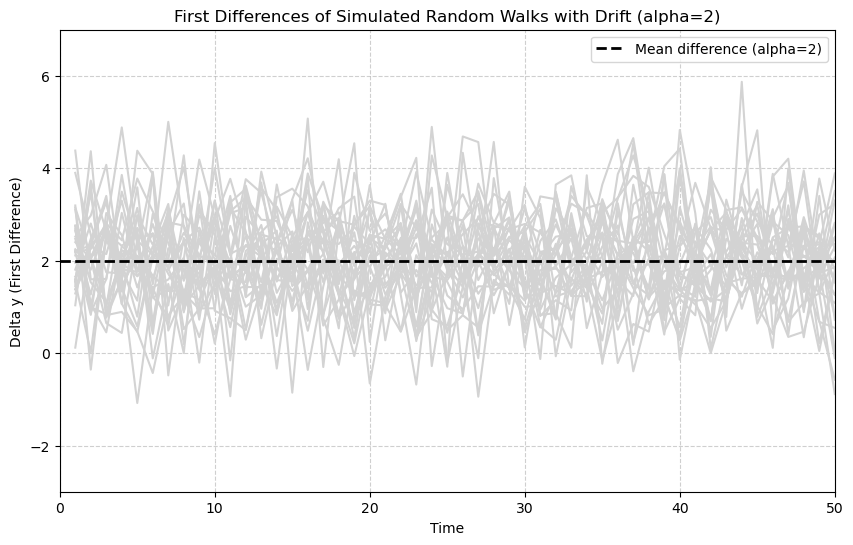

In [8]:
# Reset the seed
np.random.seed(1234567)

# Initialize plot settings
x_range = np.linspace(1, 50, num=50)  # Time periods 1 to 50 for the differences
plt.figure(figsize=(10, 6))
plt.ylim([-3, 7])  # Adjusted ylim based on alpha + e_t (mean 2)
plt.xlim([0, 50])

# Simulate and plot first differences of 30 random walks with drift = 2
for r in range(30):
    # Generate shocks e_1, ..., e_50 (we need 51 points for y, 50 for diff)
    e = stats.norm.rvs(0, 1, size=51)
    # No need to set e[0]=0 if we calculate y directly with drift
    # Construct y_t = y_0 + alpha*t + cumsum(e), assume y_0=0, alpha=2
    # A slightly more direct way to get the difference: Dy_t = alpha + e_t
    # Note: the simulation below uses cumsum(2+e), which gives y_t = sum_{i=1}^t (2+e_i).
    # Then Dy_t = y_t - y_{t-1} = (2+e_t). This is equivalent.
    y = np.cumsum(
        2 + e,
    )  # Generates y_1, ..., y_51 with drift 2, starting implicitly from y_0=0

    # Calculate the first difference: Delta y_t = y_t - y_{t-1} for t=1,...,50
    # This gives 50 difference values.
    Dy = y[1:51] - y[0:50]  # Difference uses elements 1 to 50 and 0 to 49

    # Add the difference series to the plot
    plt.plot(x_range, Dy, color="lightgrey", linestyle="-")

# Add a horizontal line at the mean of the difference (alpha = 2)
plt.axhline(
    y=2,
    linewidth=2,
    linestyle="--",
    color="black",
    label="Mean difference (alpha=2)",
)
plt.ylabel("Delta y (First Difference)")
plt.xlabel("Time")
plt.title("First Differences of Simulated Random Walks with Drift (alpha=2)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Observation: The first difference series (Delta y) now appears stationary. The paths fluctuate
# around a constant mean (alpha = 2) and do not exhibit the wandering behavior or trend seen
# in the levels (y). The variance seems constant over time. This illustrates how differencing
# can transform a non-stationary I(1) process into a stationary I(0) process.

## 11.4 Regression with First Differences

Regressing one I(1) variable on another can lead to **spurious regression**: finding a statistically significant relationship (high R-squared, significant t-stats) even when the variables are truly unrelated, simply because both are trending over time due to their I(1) nature.

One common approach to avoid spurious regression when dealing with I(1) variables is to estimate the regression model using **first differences**. If the original model is:
$$ y_t = \beta_0 + \beta_1 x_t + u_t $$
and both $y_t$ and $x_t$ are I(1), we can difference the equation to get:
$$ \Delta y_t = \beta_1 \Delta x_t + \Delta u_t $$
(Note: The intercept $\beta_0$ differences out if it represents a constant level. If the original model included a time trend, differencing would result in a constant term in the differenced equation.)

If $\Delta y_t$ and $\Delta x_t$ are stationary (I(0)), then OLS estimation of the differenced equation yields valid results. The coefficient $\beta_1$ retains its interpretation as the effect of a change in $x$ on $y$.

### Example 11.6: Fertility Equation

Let's revisit the relationship between the general fertility rate (`gfr`) and the real value of the personal exemption (`pe`) from the `fertil3` dataset. Both `gfr` and `pe` might be I(1) processes. We estimate the relationship using first differences.

In [9]:
# Load the fertil3 data
fertil3 = wool.data("fertil3")
T = len(fertil3)

# Define yearly time index
fertil3.index = pd.date_range(start="1913", periods=T, freq="YE").year

# Compute first differences of gfr and pe using pandas .diff() method
# .diff(1) calculates the difference between an element and the previous element.
fertil3["gfr_diff1"] = fertil3["gfr"].diff()
fertil3["pe_diff1"] = fertil3["pe"].diff()

# Display the first few rows showing the original variables and their differences
# Note that the first row of the differenced variables will be NaN (Not a Number).
print("First few rows with differenced variables:")
print(f"{fertil3[['gfr', 'pe', 'gfr_diff1', 'pe_diff1']].head()}\n")

First few rows with differenced variables:
             gfr     pe  gfr_diff1  pe_diff1
1913  124.699997   0.00        NaN       NaN
1914  126.599998   0.00   1.900002      0.00
1915  125.000000   0.00  -1.599998      0.00
1916  123.400002   0.00  -1.599998      0.00
1917  121.000000  19.27  -2.400002     19.27



Now, we regress the first difference of `gfr` on the first difference of `pe`. `statsmodels` automatically drops rows with NaN values, so the first observation is excluded.

In [10]:
# Estimate the linear regression using first differences
# Delta(gfr_t) = beta_0 + beta_1 * Delta(pe_t) + error_t
# Note: The intercept here (beta_0) represents the average annual change in gfr
# NOT accounted for by changes in pe. It captures any underlying linear trend in gfr.
reg1 = smf.ols(formula="gfr_diff1 ~ pe_diff1", data=fertil3)
results1 = reg1.fit()

# Display the regression results
table1 = pd.DataFrame(
    {
        "b": round(results1.params, 4),
        "se": round(results1.bse, 4),
        "t": round(results1.tvalues, 4),
        "pval": round(results1.pvalues, 4),
    },
)
print("--- Regression in First Differences: Delta(gfr) ~ Delta(pe) ---")
print(f"table1: \n{table1}\n")

# Interpretation (Differenced Model):
# The coefficient on Delta(pe) (pe_diff1) is -0.0418 and is statistically significant (p=0.029).
# This suggests that a $1 increase in the change of the personal exemption from one year
# to the next is associated with a decrease of about 0.04 points in the change of the
# fertility rate in the same year. This differs from the results obtained using levels in Chapter 10,
# highlighting how accounting for persistence can change conclusions.
# The intercept (-0.6734) suggests a slight downward trend in gfr after accounting for changes in pe.

--- Regression in First Differences: Delta(gfr) ~ Delta(pe) ---
table1: 
                b      se       t    pval
Intercept -0.7848  0.5020 -1.5632  0.1226
pe_diff1  -0.0427  0.0284 -1.5045  0.1370



We can also include lags of the differenced explanatory variable, similar to an FDL model but applied to differences.

In [11]:
# Create lagged first differences of pe
fertil3["pe_diff1_lag1"] = fertil3["pe_diff1"].shift(1)
fertil3["pe_diff1_lag2"] = fertil3["pe_diff1"].shift(2)

# Estimate the regression with current and lagged first differences of pe
# Delta(gfr_t) = beta_0 + delta_0*Delta(pe_t) + delta_1*Delta(pe_{t-1}) + delta_2*Delta(pe_{t-2}) + error_t
reg2 = smf.ols(
    formula="gfr_diff1 ~ pe_diff1 + pe_diff1_lag1 + pe_diff1_lag2",
    data=fertil3,
)
results2 = reg2.fit()

# Display the regression results
table2 = pd.DataFrame(
    {
        "b": round(results2.params, 4),
        "se": round(results2.bse, 4),
        "t": round(results2.tvalues, 4),
        "pval": round(results2.pvalues, 4),
    },
)
print("--- Regression with Lagged First Differences ---")
print("Dependent Variable: Delta(gfr)")
print(f"table2: \n{table2}\n")

# Interpretation (Lagged Differences):
# - The contemporaneous effect (pe_diff1) is -0.0341 (p=0.072), marginally significant.
# - The first lag (pe_diff1_lag1) has a coefficient of -0.0112 (p=0.648), insignificant.
# - The second lag (pe_diff1_lag2) has a coefficient of -0.1143 (p=0.001), highly significant.
# These results suggest that changes in the personal exemption have a delayed effect on changes
# in the fertility rate, with the strongest impact appearing two years later.
# This aligns somewhat with the FDL model in levels (Example 10.4), which also found the second lag significant.
# The Long-Run Propensity (LRP) in this differenced model would be estimated by summing the delta coefficients.

--- Regression with Lagged First Differences ---
Dependent Variable: Delta(gfr)
table2: 
                    b      se       t    pval
Intercept     -0.9637  0.4678 -2.0602  0.0434
pe_diff1      -0.0362  0.0268 -1.3522  0.1810
pe_diff1_lag1 -0.0140  0.0276 -0.5070  0.6139
pe_diff1_lag2  0.1100  0.0269  4.0919  0.0001



This notebook covered essential issues when applying OLS to time series: the importance of stationarity and weak dependence for asymptotics, the characteristics of highly persistent I(1) processes like random walks, and the use of first differencing as a technique to handle non-stationarity and avoid spurious regressions.